In [1]:
!pip install -q "transformers>=4.49.0" accelerate datasets "qwen-vl-utils[decord]==0.0.8"

In [2]:
import os
from google.colab import userdata
import json
import PIL

os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')

from datasets import load_dataset
dataset = load_dataset("zackriya/diagramJSON",)

In [3]:
import torch
from transformers import Qwen2_5_VLForConditionalGeneration, Qwen2_5_VLProcessor


MODEL_ID="mohammedsafvan/qwen-2.5-vl-instruct-diagram-json"
MAX_PIXELS = 1280 * 28 * 28
MIN_PIXELS = 256 * 28 * 28


model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    MODEL_ID,
    device_map="auto",
    torch_dtype=torch.bfloat16
)

processor = Qwen2_5_VLProcessor.from_pretrained(
    MODEL_ID,
    min_pixels=MIN_PIXELS,
    max_pixels=MAX_PIXELS
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
train_dataset = dataset['train']
eval_dataset = dataset['test']

SYSTEM_MESSAGE = """You are a Vision Language Model specialized in extracting structured data from visual representations of process and flow diagrams.
Your task is to analyze the provided image of a diagram and extract the relevant information into a well-structured JSON format.
The diagram includes details such as nodes and edges. each of them have their own attributes.
Focus on identifying key data fields and ensuring the output adheres to the requested JSON structure.
Provide only the JSON output based on the extracted information. Avoid additional explanations or comments."""


In [4]:
def format_data(entry):
    return [
        {
            "role": "system",
            "content": [{"type": "text", "text": SYSTEM_MESSAGE}],
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    # this image is handled by qwen_vl_utils's process_visio_Info so no need to worry about pil image or path
                    "image": entry["image"],
                },
                {
                    "type": "text",
                    "text": "Extract data in JSON format",
                },
            ],
        },
        {
            "role": "assistant",
            "content": [{"type": "text", "text": entry["json_string"]}],
        },
    ]

In [ ]:

train_dataset = [ (entry,format_data(entry)) for entry in train_dataset]
eval_dataset = [ (entry,format_data(entry)) for entry in eval_dataset]

In [ ]:
entry, conversation = eval_dataset[10]
label = entry['json_string']
conversation = conversation[:2]
label

'{"nodes": [{"id": "1", "type_of_node": "start", "shape": "start_event", "label": "Lamp doesn\'t work"}, {"id": "2", "type_of_node": "decision", "shape": "gateway", "label": "Lamp plugged in?"}, {"id": "3", "type_of_node": "process", "shape": "task", "label": "Plug in lamp"}, {"id": "4", "type_of_node": "decision", "shape": "gateway", "label": "Lamp plugged in?"}, {"id": "5", "type_of_node": "process", "shape": "task", "label": "Replace bulb"}, {"id": "6", "type_of_node": "process", "shape": "task", "label": "PRINT K"}], "edges": [{"source": "1", "source_type": "start", "source_label": "Lamp doesn\'t work", "target": "2", "target_type": "decision", "target_label": "Lamp plugged in?", "type_of_edge": "solid", "relationship_value": "", "relationship_type": "follows"}, {"source": "2", "source_type": "decision", "source_label": "Lamp plugged in?", "target": "3", "target_type": "process", "target_label": "Plug in lamp", "type_of_edge": "solid", "relationship_value": "No", "relationship_type

In [6]:
from qwen_vl_utils import process_vision_info

def run_inference(model, processor, conversation, max_new_tokens=1024, device='cuda'):
    text = processor.apply_chat_template(conversation, tokenize=False, add_generation_prompt=True)
    image_inputs, _ = process_vision_info(conversation)

    inputs = processor(
        text=[text],
        images=image_inputs,
        return_tensors="pt",
    )
    inputs = inputs.to(device)

    generated_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)
    generated_ids_trimmed = [
        out_ids[len(in_ids):]
        for in_ids, out_ids
        in zip(inputs.input_ids, generated_ids)
    ]

    output_text = processor.batch_decode(
        generated_ids_trimmed,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )
    return output_text[0]

In [ ]:
generated_label = run_inference(model, processor, conversation)
generated_label

'{"nodes": [{"id": "1", "type_of_node": "start", "shape": "start_event", "label": "Lamp doesn\'t work"}, {"id": "2", "type_of_node": "decision", "shape": "gateway", "label": "Lamp plugged in?"}, {"id": "3", "type_of_node": "process", "shape": "task", "label": "Plug in lamp"}, {"id": "4", "type_of_node": "decision", "shape": "gateway", "label": "Lamp plugged in?"}, {"id": "5", "type_of_node": "process", "shape": "task", "label": "Replace bulb"}, {"id": "6", "type_of_node": "terminator", "shape": "end_event", "label": "PRINT K"}], "edges": [{"source": "1", "source_type": "start", "source_label": "Lamp doesn\'t work", "target": "2", "target_type": "decision", "target_label": "Lamp plugged in?", "type_of_edge": "solid", "relationship_value": "", "relationship_type": "follows"}, {"source": "2", "source_type": "decision", "source_label": "Lamp plugged in?", "target": "3", "target_type": "process", "target_label": "Plug in lamp", "type_of_edge": "solid", "relationship_value": "No", "relations

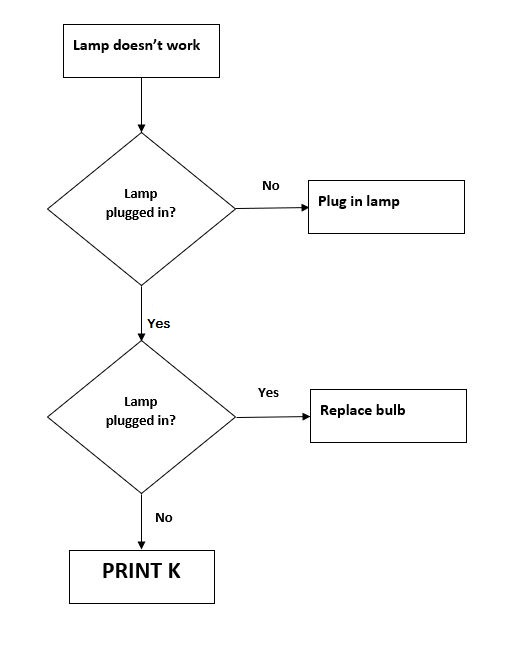

In [ ]:
entry['image']

In [ ]:
json.loads(generated_label)

{'nodes': [{'id': '1',
   'type_of_node': 'start',
   'shape': 'start_event',
   'label': "Lamp doesn't work"},
  {'id': '2',
   'type_of_node': 'decision',
   'shape': 'gateway',
   'label': 'Lamp plugged in?'},
  {'id': '3',
   'type_of_node': 'process',
   'shape': 'task',
   'label': 'Plug in lamp'},
  {'id': '4',
   'type_of_node': 'decision',
   'shape': 'gateway',
   'label': 'Lamp plugged in?'},
  {'id': '5',
   'type_of_node': 'process',
   'shape': 'task',
   'label': 'Replace bulb'},
  {'id': '6',
   'type_of_node': 'terminator',
   'shape': 'end_event',
   'label': 'PRINT K'}],
 'edges': [{'source': '1',
   'source_type': 'start',
   'source_label': "Lamp doesn't work",
   'target': '2',
   'target_type': 'decision',
   'target_label': 'Lamp plugged in?',
   'type_of_edge': 'solid',
   'relationship_value': '',
   'relationship_type': 'follows'},
  {'source': '2',
   'source_type': 'decision',
   'source_label': 'Lamp plugged in?',
   'target': '3',
   'target_type': 'proce

In [8]:
!pip install nltk
import nltk

In [12]:
#!rm -rf images results output.csv

In [ ]:
import os
import time
import json
import csv
import nltk

os.makedirs('images', exist_ok=True)
os.makedirs('results', exist_ok=True)


for idx, (entry, conversation) in enumerate(eval_dataset):
  label = entry['json_string']
  conversation = conversation[:2]
  filename= entry['filename'].split('.')[0]
  print("===================================================")
  print(f'Generating for {idx+1} with image')
  start_time = time.perf_counter()
  generated_label = run_inference(model, processor, conversation)
  end_time = time.perf_counter()
  inference_time = end_time - start_time
  print(f"Inference time: {inference_time:0.4f} seconds")

  # Save the generated JSON
  output_filename = os.path.join('results', f"{filename}.json")
  try:
    with open(output_filename, 'w') as f:
        json.dump(json.loads(generated_label), f, indent=4)
  except Exception as e:
    print(f"Error saving JSON file for {idx}, : {e}!!!!!!!!!!!!!!!!!!!!!!!!")
    print(f"""json is : {generated_label}""")

  image_filename = os.path.join('images', f"{filename}.png")
  image = entry['image']
  image_size = str(image.size)
  image.save(image_filename)

  score = nltk.edit_distance(generated_label, label)
  normalized_score = score / max(len(generated_label), len(label))
  print(f"Processed {idx+1}/{len(eval_dataset)} images, Score = {score} normalized score = {normalized_score}")
  print("==================================================")

  with open('output.csv', 'a', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow([filename,inference_time,image_size, normalized_score, score])

Generating for 1 with image
Inference time: 57.6303 seconds
Processed 1/20 images, Score = 44 normalized score = 0.01818181818181818
Generating for 2 with image
Inference time: 47.9817 seconds
Processed 2/20 images, Score = 753 normalized score = 0.26636009904492397
Generating for 3 with image
Inference time: 70.6463 seconds
Processed 3/20 images, Score = 672 normalized score = 0.22325581395348837
Generating for 4 with image
Inference time: 30.4462 seconds
Processed 4/20 images, Score = 27 normalized score = 0.020316027088036117
Generating for 5 with image
Inference time: 32.3536 seconds
Processed 5/20 images, Score = 0 normalized score = 0.0
Generating for 6 with image
Inference time: 55.6261 seconds
Processed 6/20 images, Score = 200 normalized score = 0.08097165991902834
Generating for 7 with image
Inference time: 45.2298 seconds
Processed 7/20 images, Score = 286 normalized score = 0.13289962825278812
Generating for 8 with image
Inference time: 33.4335 seconds
Processed 8/20 images

In [14]:
!zip -r it2.zip results/ images/ output.csv

  adding: results/ (stored 0%)
  adding: results/728.json (deflated 86%)
  adding: results/930.json (deflated 88%)
  adding: results/813.json (deflated 85%)
  adding: results/652.json (stored 0%)
  adding: results/259.json (deflated 88%)
  adding: results/39.json (deflated 81%)
  adding: results/937.json (stored 0%)
  adding: results/563.json (deflated 88%)
  adding: results/171.json (deflated 88%)
  adding: results/418.json (deflated 88%)
  adding: results/45.json (deflated 87%)
  adding: results/914.json (deflated 88%)
  adding: results/332.json (deflated 85%)
  adding: results/634.json (deflated 90%)
  adding: results/701.json (deflated 86%)
  adding: results/113.json (deflated 89%)
  adding: results/345.json (deflated 88%)
  adding: results/76.json (deflated 87%)
  adding: results/37.json (deflated 88%)
  adding: results/49.json (deflated 84%)
  adding: images/ (stored 0%)
  adding: images/930.png (deflated 3%)
  adding: images/37.png (deflated 0%)
  adding: images/813.png (deflate